In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter
from lifelines.utils import concordance_index
import math

In [2]:
df = pd.read_excel('clean_data/companies_ratio_final.xlsx')
not_covariates = ['qdate', 'Name', 'distress', 'start', 'stop']
covariates_to_del = ['max_drawdown', 'PRC', 'RET', 'dPRC', 'dRET']
df = df.drop(columns=covariates_to_del)

covariates = [col for col in df.columns if col not in not_covariates]
macro_covariates = ['HPI', 'TEDRATE', 'UNRATE', 'DELINQRATE']


# drop data before '2002-06-31' because of the effects of the dot-com bubble
df = df[(df['qdate'] >= pd.to_datetime('2002-06-30'))]
# df = df[(df['qdate'] <= '2009-08-25')]

# Normalization
# Company wise normalization
comp_norm = [c for c in covariates if c not in macro_covariates]
# Global normalization
glob_norm = [cova for cova in covariates if (cova not in comp_norm) and (cova not in macro_covariates)]
# glob_norm = [cova for cova in covariates if (cova not in comp_norm) and (cova not in macro_covariates)]
print(comp_norm)
print(glob_norm)
# Normalize the data for each company
for Name in df['Name'].unique():
    for column in comp_norm:
        df.loc[df['Name'] == Name, column] = (df[df['Name'] == Name][column] - df[df['Name'] == Name][column].mean()) / df[df['Name'] == Name][column].std()
# Normalize the data globally
for column in glob_norm:
        df[column] = (df[column] - df[column].mean()) / df[column].std()

df

['cash_lt', 'debt_at', 'short_debt', 'lt_debt', 'cash_debt', 'debt_assets', 'debt_capital', 'de_ratio', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'delinq_rate', 'dcash_lt', 'ddebt_at', 'dshort_debt', 'dlt_debt', 'dcash_debt', 'ddebt_assets', 'ddebt_capital', 'dde_ratio', 'dinv_turn', 'dat_turn', 'drect_turn', 'dpay_turn', 'dsale_invcap', 'dsale_equity', 'dHPI', 'dTEDRATE', 'dUNRATE', 'dDELINQRATE']
[]


,qdate,cash_lt,debt_at,short_debt,lt_debt,cash_debt,debt_assets,debt_capital,de_ratio,inv_turn,...,dat_turn,drect_turn,dpay_turn,dsale_invcap,dsale_equity,dHPI,dTEDRATE,dUNRATE,dDELINQRATE,distress
11,2002-06-30,-0.624900,0.055388,0.821059,-0.081217,2.709578,-5.224503e-01,-0.508572,-0.541780,1.367773,...,-1.036484,-1.089693,-0.504320,-0.695613,-0.530289,0.832316,0.001906,-0.561051,-0.758680,0
12,2002-09-30,-0.426669,-0.046345,0.586966,-0.123963,2.709578,-3.731788e-01,-0.217960,-0.405400,1.422031,...,-0.698500,-1.089693,0.233709,-0.227139,-0.288463,0.355459,0.116267,-0.576775,-0.847905,0
13,2002-12-31,0.224662,-0.487187,1.523338,-0.807897,1.279302,-7.463575e-02,0.072653,-0.108424,1.663678,...,-0.360516,-0.035151,-0.504320,2.200409,-0.167551,0.128063,-0.118173,-0.073621,-0.691849,0
14,2003-03-31,0.252981,-0.385454,-0.219354,-0.337692,1.279302,-7.463575e-02,0.072653,-0.117346,1.241549,...,-0.698500,-0.386665,-0.873334,-1.632561,0.074275,0.436799,-0.032402,0.130785,-0.936801,0
15,2003-06-30,1.017586,-0.521098,-0.362410,-0.487303,1.279302,3.731788e-01,0.363266,0.271400,0.680560,...,-0.698500,-0.386665,-1.242348,0.198747,-0.133004,0.754535,0.121985,0.170356,-0.849910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2007-06-30,-0.119952,-1.057863,-0.563930,0.180242,1.095445,-1.655023e-14,-0.030254,-0.086126,-0.929326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1436,2007-09-30,-0.179928,-0.817440,-1.024566,1.081454,1.095445,-4.472136e-01,-0.332799,-0.416308,-0.689809,...,0.921714,0.898177,-0.807134,0.479331,0.155928,0.195006,1.412606,-0.729392,-1.142147,0
1437,2007-12-31,-1.139544,1.346372,1.613622,-1.622181,-0.730297,-1.043498e+00,-1.089160,-0.978083,-0.182033,...,0.806500,0.785905,-0.201784,-1.345218,-1.418204,-1.312726,-0.183413,0.069573,-0.287833,0
1438,2008-03-31,-0.179928,0.625101,0.106086,0.405545,-0.730297,-1.490712e-01,-0.181527,-0.199597,0.191614,...,-0.921714,-1.122722,-0.443924,0.974123,0.920719,0.004751,-0.286382,-0.729681,0.171745,0


<lifelines.CoxTimeVaryingFitter: fitted with 882 periods, 37 subjects, 19 events>
         event col = 'distress'
number of subjects = 37
 number of periods = 882
  number of events = 19
partial log-likelihood = -45.13
  time fit was run = 2024-10-08 04:32:12 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
inv_turn      0.43      1.54      0.20            0.03            0.84                1.03                2.31
rect_turn    -1.03      0.36      0.29           -1.59           -0.46                0.20                0.63
ddebt_assets  0.38      1.47      0.15            0.08            0.69                1.09                1.99
dinv_turn     0.38      1.46      0.18            0.02            0.74                1.02                2.09

              cmp to     z      p  -log2(p)
covariate                                  
inv_turn        0.00  2.13   0.03      4.90
rect_turn       0.00 -3.57 <0.005     11.44
ddebt_assets    0.00  2.49   0.01      6.31
dinv_turn       0.00  2.08   0.04      4.75
---
Partial AIC = 98.26
log-likelihood ratio test = 33.41 on 4 df
-log2(p) of ll-ratio test = 19.95

Concordance index: 0.40


,inv_turn,rect_turn,ddebt_assets,dinv_turn
inv_turn,1.000000,0.070371,0.009263,0.362695
rect_turn,0.070371,1.000000,0.002807,0.049519
ddebt_assets,0.009263,0.002807,1.000000,0.012090
dinv_turn,0.362695,0.049519,0.012090,1.000000


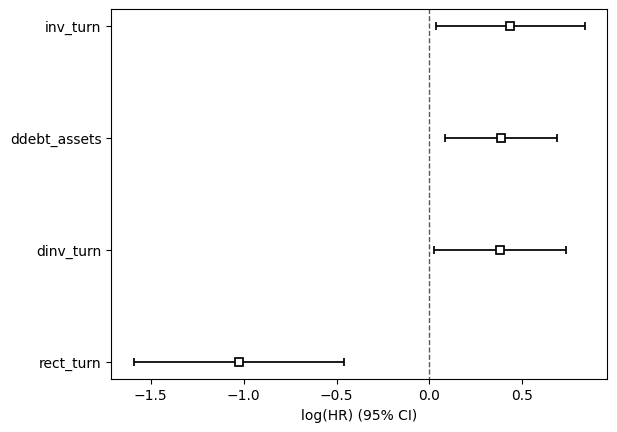

In [38]:
final_df = df.copy()
covariates_to_keep =  'inv_turn, rect_turn, ddebt_assets, dinv_turn'.split(', ')
final_df = final_df.drop(columns=([col for col in covariates if col not in covariates_to_keep]))
df_dates = final_df.copy()
df_dates.dropna(inplace=True)
final_df.drop(columns=['qdate'], inplace=True)
final_df.dropna(inplace=True)

ctv = CoxTimeVaryingFitter(penalizer=0.0, alpha=0.05, l1_ratio=0.0)
ctv.fit(final_df, id_col="Name", event_col="distress", start_col="start", stop_col="stop", show_progress=False)
ctv.print_summary()
# Compute the partial hazards
partial_hazards = ctv.predict_partial_hazard(final_df)

# Compute the concordance index
cindex = concordance_index(event_times=final_df['stop'],
                            predicted_scores=partial_hazards.values.flatten(),
                            event_observed=final_df['distress'])
print('Concordance index: {:.2f}'.format(cindex))
ctv.plot()
df[covariates_to_keep].corr().abs().style.background_gradient(cmap='coolwarm')